In [1]:
# Import libraries 
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob 
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
Emotions= pd.read_csv('/kaggle/input/emotion/emotion (1).csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,labels
0,-258.990326,132.193741,5.314349,21.521330,-24.357752,-2.237025,-24.086287,-9.530801,-20.967497,-4.285268,...,-0.953883,1.146237,1.829600,2.893938,1.310414,1.626812,2.758013,4.257873,3.918041,male_happy
1,-258.667152,132.047682,5.236842,21.529129,-24.335813,-2.170860,-24.135509,-9.465332,-20.959675,-4.215839,...,-0.906946,1.140402,1.826270,2.867984,1.350153,1.576485,2.766849,4.228887,3.915566,male_happy
2,-301.181824,128.659897,4.380285,9.940308,-23.697367,-7.601327,-25.921268,-13.189119,-19.924520,-0.300373,...,3.321182,3.191138,3.419615,3.112536,1.654553,3.749860,5.546700,4.269989,1.401541,male_happy
3,-274.135437,142.405472,-2.322214,21.200804,-27.737436,-1.496183,-26.762552,-10.112954,-21.643480,-3.658734,...,-1.149690,1.346368,2.298612,3.353943,1.820001,2.129130,2.610373,4.910376,4.944275,male_happy
4,-274.135437,142.405472,-2.322214,21.200804,-27.737436,-1.496183,-26.762552,-10.112954,-21.643480,-3.658734,...,-1.149690,1.346368,2.298612,3.353943,1.820001,2.129130,2.610373,4.910376,4.944275,male_happy


In [3]:
X = Emotions.drop('labels',axis = 1)
Y = Emotions['labels']

In [4]:
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

In [5]:
# since it is a multiclass classifier, i will perform onehotencoding
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [6]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.2,shuffle = True)

x_train.shape,y_train.shape,x_test.shape,y_test.shape

((48648, 40), (48648, 14), (12162, 40), (12162, 14))

In [7]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((48648, 40), (48648, 14), (12162, 40), (12162, 14))

CNN

In [8]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D,Dense,AveragePooling1D,Dropout,add,BatchNormalization,LSTM,Flatten,MaxPooling1D,GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu, softmax
from keras.activations import relu, softmax
from sklearn.metrics import confusion_matrix,classification_report

In [9]:
x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

((48648, 40, 1), (48648, 14), (12162, 40, 1), (12162, 14))

In [15]:
my_model=Sequential()
my_model.add(Conv1D(256, kernel_size=7, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
my_model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
my_model.add(BatchNormalization())

my_model.add(Conv1D(128, kernel_size=7, strides=1, padding='same', activation='relu'))
my_model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
my_model.add(BatchNormalization())

my_model.add(Conv1D(128, kernel_size=7, strides=1, padding='same', activation='relu'))
my_model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
my_model.add(BatchNormalization())


my_model.add(Conv1D(64, kernel_size=7, strides=1, padding='same', activation='relu'))
my_model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
my_model.add(BatchNormalization())
my_model.add(Dropout(0.5))

my_model.add(LSTM(70,return_sequences=True))
my_model.add(LSTM(50,return_sequences=True))
my_model.add(LSTM(60))
        
my_model.add(Flatten())
my_model.add(Dense(units=32, activation='relu'))
my_model.add(Dropout(0.5))



my_model.add(Dense(units=14, activation='softmax'))
my_model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

my_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 40, 256)           2048      
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 20, 256)          0         
 g1D)                                                            
                                                                 
 batch_normalization_16 (Bat  (None, 20, 256)          1024      
 chNormalization)                                                
                                                                 
 conv1d_17 (Conv1D)          (None, 20, 128)           229504    
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 10, 128)          0         
 g1D)                                                            
                                                      

In [16]:
history = my_model.fit(x_traincnn, y_train, batch_size=32, epochs=100, validation_data=(x_testcnn, y_test))

Epoch 1/100
1521/1521 [==============================] - 34s 15ms/step - loss: 1.7563 - accuracy: 0.3871 - val_loss: 1.3199 - val_accuracy: 0.5175
Epoch 2/100
1521/1521 [==============================] - 21s 14ms/step - loss: 1.4140 - accuracy: 0.4964 - val_loss: 1.2218 - val_accuracy: 0.5402
Epoch 3/100
1521/1521 [==============================] - 22s 14ms/step - loss: 1.3142 - accuracy: 0.5233 - val_loss: 1.1478 - val_accuracy: 0.5643
Epoch 4/100
1521/1521 [==============================] - 22s 14ms/step - loss: 1.2380 - accuracy: 0.5500 - val_loss: 1.1090 - val_accuracy: 0.5779
Epoch 5/100
1521/1521 [==============================] - 23s 15ms/step - loss: 1.1945 - accuracy: 0.5640 - val_loss: 1.0673 - val_accuracy: 0.6029
Epoch 6/100
1521/1521 [==============================] - 22s 14ms/step - loss: 1.1317 - accuracy: 0.5835 - val_loss: 1.0697 - val_accuracy: 0.6054
Epoch 7/100
1521/1521 [==============================] - 22s 14ms/step - loss: 1.0827 - accuracy: 0.6037 - val_loss: 1

In [17]:
print("Accuracy of our model on test data : " , round(my_model.evaluate(x_testcnn,y_test)[1],2)*100 , "%")

381/381 [==============================] - 2s 6ms/step - loss: 1.1793 - accuracy: 0.8262
Accuracy of our model on test data :  83.0 %


In [18]:
model_name = 'emotion_model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)   # adds file in folder
my_model.save(model_path)
print('Save model and weights at %s' % model_path)
model_json = my_model.to_json()
with open('model_json.json', 'w') as json_file:
    json_file.write(model_json)

Save model and weights at /kaggle/working/saved_models/emotion_model.h5


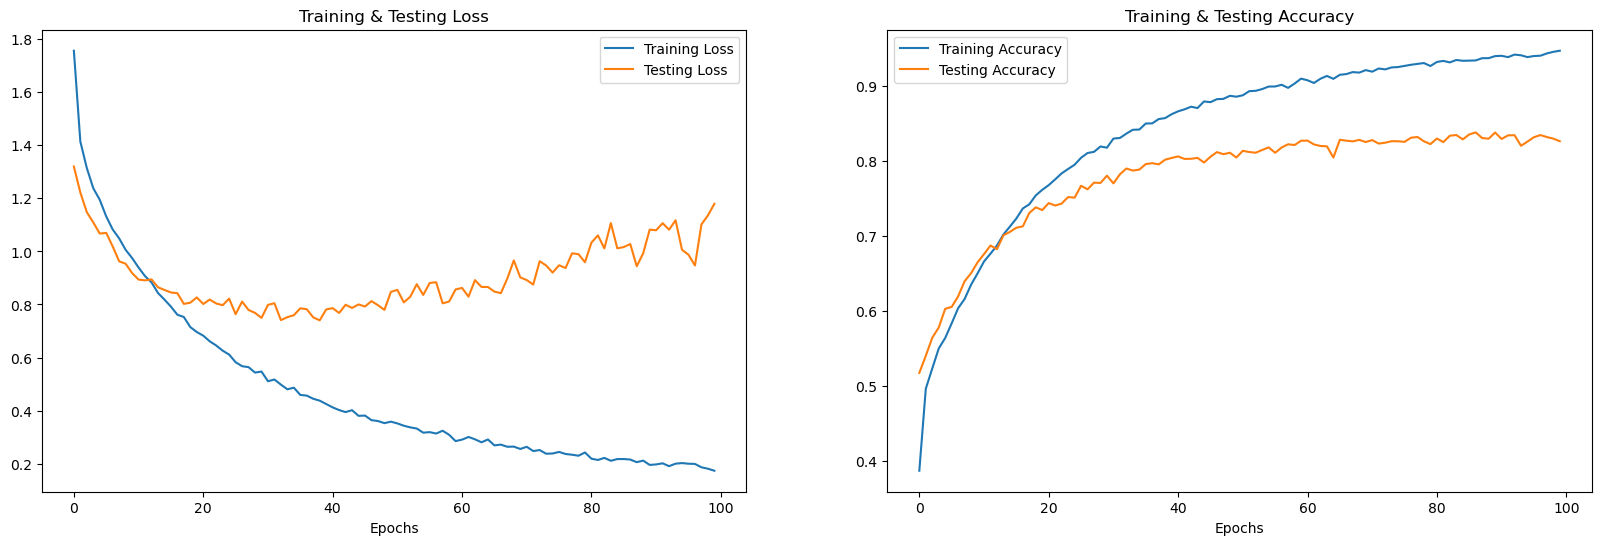

In [19]:
epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

Confusion Matrix

In [20]:
# predicting on test data.
pred_test = my_model.predict(x_testcnn)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

381/381 [==============================] - 3s 4ms/step


In [21]:
df = pd.DataFrame(columns=['PredictedLabels', 'ActualLabels'])
df['PredictedLabels'] = y_pred.flatten()
df['ActualLabels'] = y_test.flatten()


In [22]:
df

,PredictedLabels,ActualLabels
0,female_neutral,female_neutral
1,female_angry,female_angry
2,female_neutral,female_neutral
3,female_disgust,female_disgust
4,female_happy,female_happy
...,...,...
12157,male_happy,male_happy
12158,female_happy,female_happy
12159,female_sad,female_sad
12160,male_happy,male_happy


In [23]:
df.to_csv('Predictions.csv', index = False)

In [25]:
import seaborn as sns

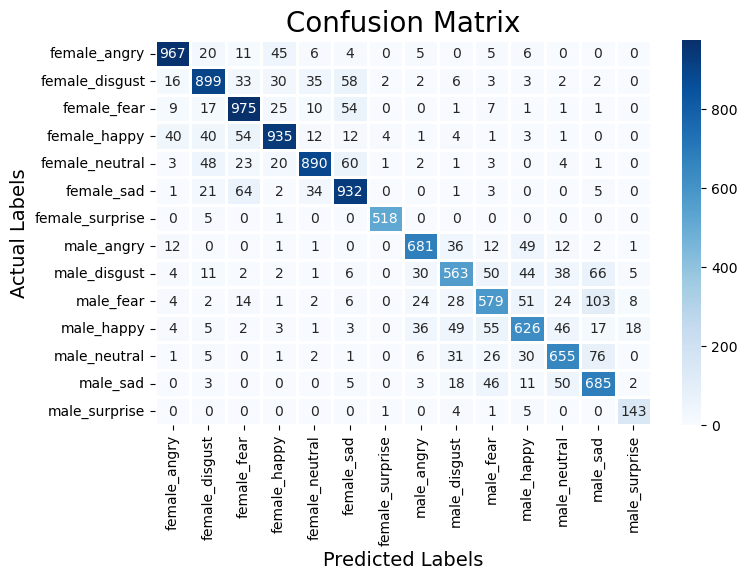

In [26]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (8,5))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [27]:
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

   female_angry       0.91      0.90      0.91      1069
 female_disgust       0.84      0.82      0.83      1091
    female_fear       0.83      0.89      0.86      1101
   female_happy       0.88      0.84      0.86      1107
 female_neutral       0.90      0.84      0.87      1056
     female_sad       0.82      0.88      0.85      1063
female_surprise       0.98      0.99      0.99       524
     male_angry       0.86      0.84      0.85       807
   male_disgust       0.76      0.68      0.72       822
      male_fear       0.73      0.68      0.71       846
     male_happy       0.76      0.72      0.74       865
   male_neutral       0.79      0.79      0.79       834
       male_sad       0.72      0.83      0.77       823
  male_surprise       0.81      0.93      0.86       154

       accuracy                           0.83     12162
      macro avg       0.83      0.83      0.83     12162
   weighted avg       0.83   

In [ ]:
import keras

# Emotion accuracy

In [28]:
modidf = pd.read_csv("Predictions.csv")
modidf['actualvalues'] = modidf.ActualLabels.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

In [29]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns


In [30]:
modidf['predictedvalues'] = modidf.PredictedLabels.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

classes = modidf.actualvalues.unique()  
classes.sort() 
# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))




0.8325933234665351


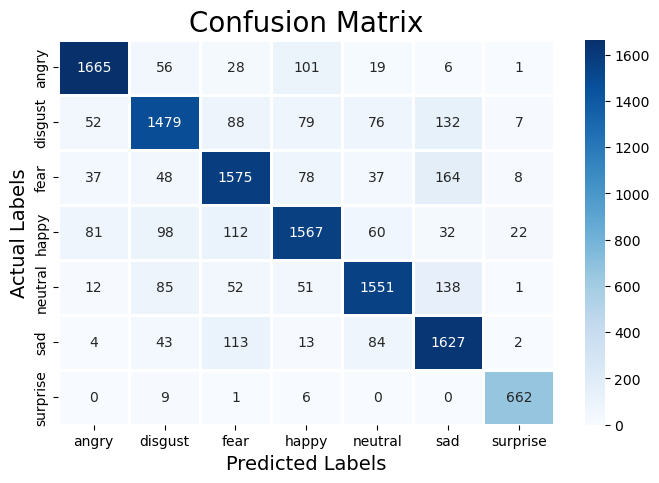

In [31]:
cm = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
plt.figure(figsize = (8,5))
x= pd.DataFrame(cm,  columns=(classes), index=(classes))
sns.heatmap(x, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

# Classification report

In [32]:
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

       angry       0.90      0.89      0.89      1876
     disgust       0.81      0.77      0.79      1913
        fear       0.80      0.81      0.80      1947
       happy       0.83      0.79      0.81      1972
     neutral       0.85      0.82      0.83      1890
         sad       0.78      0.86      0.82      1886
    surprise       0.94      0.98      0.96       678

    accuracy                           0.83     12162
   macro avg       0.84      0.85      0.84     12162
weighted avg       0.83      0.83      0.83     12162

